In [1]:
import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time

In [2]:
from GetInliersRansac import GetInliersRansac
from EssentialMatrixFromFundamentalMatrix import EssentialMatrixFromFundamentalMatrix
from ExtractCameraPose import ExtractCameraPose
from DisambiguateCameraPose import DisambiguateCameraPose
from LinearTriangulation import LinearTriangulation
from NonLinearTriangulation import NonlinearTriangulation
from LinearPNP import LinearPnP
from PNPRANSAC import PnPRANSAC, AllReprojetionError
from NonLinearPNP import NonLinearPnP
from BundleAdjustment import BundleAdjustment
from Misc.utils import PlotFuncs
from Misc.utils import MiscFuncs


In [3]:

path='/home/adinisal/adinisal_hw3/Data/Data/'

# loading images
misc_funcs = MiscFuncs()
images = misc_funcs.load_images(path)
# print(images[1])
print("loaded images\n")

# given camera calibration matrix
K = np.array([
            [568.996140852, 0, 643.21055941],
            [0, 568.988362396, 477.982801038],
            [0, 0, 1]
            ])
# define camera 1 as the world pose
M1 = np.identity(4)
M1 = M1[0:3, :]
M1 = np.dot(K, M1)
# for each image pairs compute F, E
'''.............................get inliers and fundamental matrix using RANSAC...........................'''
# load correspondences between image 1 and 2
file_name = "matches12.txt"
print("using correspondences from file "+file_name)
print("performing RANSAC to obtain F matrix\n")
pts_from_txt = misc_funcs.get_pts_from_txt(path, file_name)
pts_from_txt = np.array(pts_from_txt, np.float32)

loaded images

using correspondences from file matches12.txt
performing RANSAC to obtain F matrix



In [4]:
max_inliers_locs, min_outliers_locs, F_max_inliers, pts_left, pts_right = GetInliersRansac(pts_from_txt)
print("pts_from_txt.shape = ",pts_from_txt.shape)
print("Max inliers.shape = ", max_inliers_locs.shape)

max inliers: {} 879
pts_from_txt.shape =  (1426, 7)
Max inliers.shape =  (879, 7)


In [5]:
plot_funcs = PlotFuncs()
print("plotting correspondences between images 1 and 2\n")
plot_funcs.plot_img_correspondences(images[0], images[1], max_inliers_locs, min_outliers_locs, file_name, save=True)

plotting correspondences between images 1 and 2



In [6]:
print("estimating E matrx\n")
E = EssentialMatrixFromFundamentalMatrix(F_max_inliers, K)
print("E = ", E)
C2_list, R2_list = ExtractCameraPose(E)
print("C2_List = ", C2_list)
print("R2_List = ", R2_list)

estimating E matrx

E =  [[ 0.02654929  0.73154416  0.32491785]
 [-0.8890472   0.05045153 -0.40888834]
 [-0.20835205  0.57776921  0.14559834]]
C2_List =  [[-0.59880437 -0.19964979  0.77561156]
 [ 0.59880437  0.19964979 -0.77561156]
 [-0.59880437 -0.19964979  0.77561156]
 [ 0.59880437  0.19964979 -0.77561156]]
R2_List =  [[[-0.48756398  0.36911882 -0.79122226]
  [ 0.18538609 -0.841802   -0.50695305]
  [-0.85317839 -0.39385365  0.34200284]]

 [[-0.48756398  0.36911882 -0.79122226]
  [ 0.18538609 -0.841802   -0.50695305]
  [-0.85317839 -0.39385365  0.34200284]]

 [[ 0.97474148  0.06015422 -0.21508258]
  [-0.02295427  0.98492766  0.17143687]
  [ 0.22215343 -0.16216957  0.96143064]]

 [[ 0.97474148  0.06015422 -0.21508258]
  [-0.02295427  0.98492766  0.17143687]
  [ 0.22215343 -0.16216957  0.96143064]]]


disambiguating image 2's camera pose
Plotting the 4 camera poses ans their points 

85
794
799
80


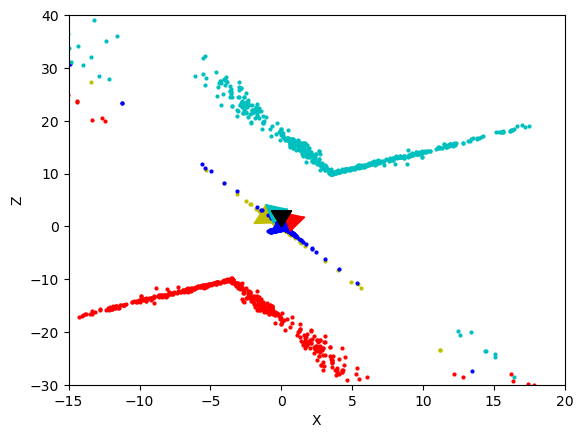

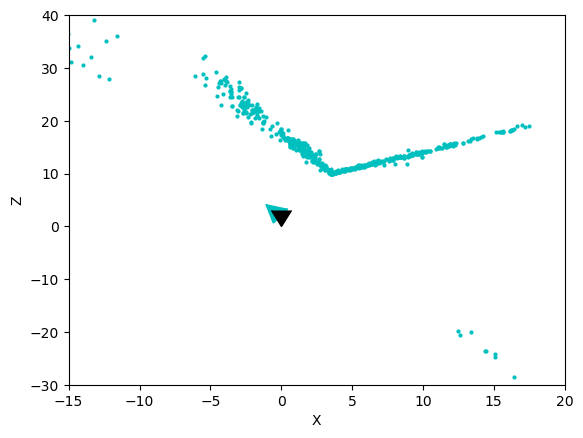



C2 =  [[-0.59880437]
 [-0.19964979]
 [ 0.77561156]]
R2 =  [[ 0.97474148  0.06015422 -0.21508258]
 [-0.02295427  0.98492766  0.17143687]
 [ 0.22215343 -0.16216957  0.96143064]]
X_list =  [[[-14.73606403]
  [ -6.67727498]
  [ 44.77884963]]

 [[-14.73606403]
  [ -6.67727498]
  [ 44.77884963]]

 [[ -0.28694655]
  [ -6.83831161]
  [ 19.61999892]]

 ...

 [[ -4.53234507]
  [-18.49804735]
  [ 24.77133683]]

 [[ -0.40044693]
  [-13.2890338 ]
  [ 17.48216668]]

 [[ -2.49940726]
  [-17.08739451]
  [ 21.57959298]]]


In [7]:
'''.............................disambiguate pose of cam 2...........................'''
print("disambiguating image 2's camera pose")
R2, C2, X_list, index = DisambiguateCameraPose(M1, C2_list, R2_list, K, max_inliers_locs)
print("C2 = ", C2)
print("R2 = ", R2)
print("X_list = ", X_list)

In [9]:
# construct projection matrix of camera 2
M2 = misc_funcs.get_projection_matrix(K, R2, C2)
reproj_errors = AllReprojetionError(max_inliers_locs[:, 2:4], M2, X_list.reshape(X_list.shape[0], 3))
mean_proj_error = {}
mean_proj_error[2] = [('LinTri', np.mean(reproj_errors))]

In [10]:
'''.............................non linear triangulation...........................'''
print("performing non-linear triangulation to refine X\n")
X_list_refined =  NonlinearTriangulation(M1, M2, X_list, max_inliers_locs, K)

performing non-linear triangulation to refine X



comapring linear and non linear triangulation



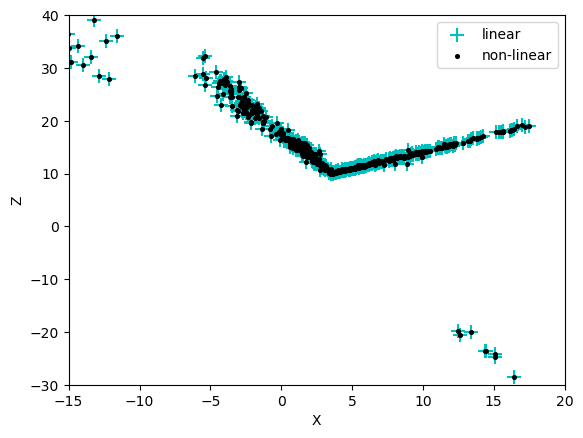

In [11]:
# compare non-linear triangulation with linear by plot
print("comapring linear and non linear triangulation\n")
plot_funcs.linear_vs_non_linear(X_list, X_list_refined, index)

In [14]:
# storing reprojection errors
reproj_errors = AllReprojetionError(max_inliers_locs[:, 2:4], M2, X_list_refined)
mean_proj_error[2].append(('NonLinTri', np.mean(reproj_errors)))
# create a dict to store all the poses
pose_set = {}
# store the pose of 1st and 2nd cam
pose_set[1] = np.identity(4)[0:3, :]
C2 = C2.reshape((3, 1))
pose_set[2] = np.hstack((R2, C2))

In [15]:
'''.............................Perspective-n-Points...........................'''
print("performing linear PnP to estimate pose of cameras 3-6")
# using correspondences between the following image pairs for PnP
image_nums = [[2, 3], [3, 4], [4, 5], [5, 6]]
print("using the image pairs --> {}\n".format(image_nums))
# create a dict consisting of 2d-3d correspondences of all images
corresp_2d_3d = {}
# X_set stores all the 3d points
X_set = []
# first we need to get inliers of image i(3-6) wrt previously estimated camera pose so that we
# match the 2D image point with the already calculated 3D point
img1_2d_3d = max_inliers_locs[:, 0:2]
X_list_refined = np.reshape(X_list_refined, (img1_2d_3d.shape[0], 3))
img1_2d_3d = np.hstack((img1_2d_3d, X_list_refined))
corresp_2d_3d[1] = img1_2d_3d
# same thing for image 2
img2_2d_3d = max_inliers_locs[:, 2:4]
img2_2d_3d = np.hstack((img2_2d_3d, X_list_refined))
corresp_2d_3d[2] = img2_2d_3d
# add the 3d points to X_set
X_set.append(X_list_refined)
X_set = np.array(X_set).reshape((X_list_refined.shape))
# map is used for BA. It stores image points and indices of corresp 3d points
map_2d_3d = {}
map_2d_3d[1] = zip(corresp_2d_3d[1][:, 0:2], range(X_set.shape[0]))
map_2d_3d[2] = zip(corresp_2d_3d[2][:, 0:2], range(X_set.shape[0]))


performing linear PnP to estimate pose of cameras 3-6
using the image pairs --> [[2, 3], [3, 4], [4, 5], [5, 6]]



In [20]:
    # estimate pose for the remaining cams

    for _, nums in enumerate(image_nums):

        ref_img_num = nums[0]
        new_img_num = nums[1]
        img_pair = str(ref_img_num)+str(new_img_num)
        file_name = "ransac"+img_pair+".txt"

        # construct projection matrix of ref image
        R_ref = pose_set[ref_img_num][:, 0:3]
        C_ref = pose_set[ref_img_num][:, 3].reshape((3, 1))
        M_ref = misc_funcs.get_projection_matrix(K, R_ref, C_ref)

        print("using correspondences from file " + file_name)

        # get the 2d-3d correspondences for the 1st ref image
        ref_img_2d_3d = corresp_2d_3d[ref_img_num]

        # next we must compare it with the points found using given matches
        matches_2d_2d = misc_funcs.get_ransac_pts_from_txt(path, file_name)
        matches_2d_2d = np.array(matches_2d_2d)

        # obtain the 3D corresp for the new image
        new_img_2d_3d, remaining_2d_2d = misc_funcs.get_2d_3d_corresp(ref_img_2d_3d, matches_2d_2d)
        print("shape of 2d-3d correspondences {}".format(np.shape(new_img_2d_3d)))

        '''.............................PnP RANSAC...........................'''
        print("performing PnP RANSAC to refine the poses")
        pose_pnp_ransac, pnp_inlier_corresp = PnPRANSAC(new_img_2d_3d, K, thresh=200)
        R_pnp = pose_pnp_ransac[:, 0:3]
        C_pnp = pose_pnp_ransac[:, 3]
        M_pnp = misc_funcs.get_projection_matrix(K, R_pnp, C_pnp)
        pts_img_pnp = new_img_2d_3d[:, 0:2]
        X_pnp = new_img_2d_3d[:, 2:5]
        reproj_errors = AllReprojetionError(pts_img_pnp, M_pnp, X_pnp)
        mean_proj_error[new_img_num] = [('LinPnP', np.mean(reproj_errors))]


        '''.............................Non-linear PnP...........................'''
        print("performing Non-linear PnP to obtain optimal pose")
        pose_non_linear = NonLinearPnP(K, pose_pnp_ransac, pnp_inlier_corresp)
        R_non_pnp = pose_non_linear[:, 0:3]
        C_non_pnp = pose_non_linear[:, 3].reshape((3, 1))
        M_non_pnp = misc_funcs.get_projection_matrix(K, R_non_pnp, C_non_pnp)
        # error is calculated for the same set of image and 3d points but with refined pose
        reproj_errors = AllReprojetionError(pts_img_pnp, M_non_pnp, X_pnp)
        mean_proj_error[new_img_num].append(('NonLinPnP', np.mean(reproj_errors)))

        '''.............................Linear triangulation...........................'''
        print("performing Linear Triangulation to obtain 3d equiv for remaining 2d points")
        # find the 2d-3d mapping for the remaining image points in the new image by doing triangulation
        X_lin_tri = LinearTriangulation(M_ref, C_non_pnp, R_non_pnp, K, remaining_2d_2d)
        X_lin_tri = X_lin_tri.reshape((remaining_2d_2d.shape[0], 3))

        remaining_2d_3d_linear = remaining_2d_2d[:, 2:4]
        print("(linear)points before adding remaining corresp - {}".format(new_img_2d_3d.shape))
        new_img_2d_3d_linear = np.vstack((new_img_2d_3d, np.hstack((remaining_2d_3d_linear, X_lin_tri))))
        print("(linear)points after adding remaining corresp - {}".format(new_img_2d_3d_linear.shape))

        # print reprojection error after non-linear triangulation
        pts_img_all_linear = new_img_2d_3d_linear[:, 0:2]
        X_all_linear = new_img_2d_3d_linear[:, 2:]
        reproj_errors = AllReprojetionError(pts_img_all_linear, M_non_pnp, X_all_linear)
        mean_proj_error[new_img_num].append(('LinTri', np.mean(reproj_errors)))


        '''.............................Non-Linear triangulation...........................'''
        print("performing Non-Linear Triangulation to obtain 3d equiv for remaining 2d points")
        X_non_lin_tri = NonlinearTriangulation(M_ref, M_non_pnp, X_lin_tri, remaining_2d_2d, K)
        X_non_lin_tri = X_non_lin_tri.reshape((remaining_2d_2d.shape[0], 3))

        remaining_2d_3d = remaining_2d_2d[:, 2:4]
        print("(Nlinear)points before adding remaining corresp - {}".format(new_img_2d_3d.shape))
        new_img_2d_3d = np.vstack((new_img_2d_3d, np.hstack((remaining_2d_3d, X_non_lin_tri))))
        print("(Nlinear)points after adding remaining corresp - {}".format(new_img_2d_3d.shape))

        # print reprojection error after non-linear triangulation
        pts_img_all = new_img_2d_3d[:, 0:2]
        X_all = new_img_2d_3d[:, 2:]
        reproj_errors = AllReprojetionError(pts_img_all, M_non_pnp, X_all)
        mean_proj_error[new_img_num].append(('NonLinTri', np.mean(reproj_errors)))

        # store the current pose after non linear pnp
        pose_set[new_img_num] = np.hstack((R_non_pnp, C_non_pnp.reshape((3, 1))))

        # plotting reprojected points
        # plot_funcs.plot_reproj_points(images[new_img_num-1], new_img_num, np.float32(pts_img_all), np.float32(pts_img_reproj_all), save=True)
        # print("plotting all the camera poses and their respective correspondences\n")
        corresp_2d_3d[new_img_num] = np.hstack((pts_img_all, X_all))
        plot_funcs.plot_camera_poses(pose_set, corresp_2d_3d, save=True)


        # do bundle adjustment
        index_start = X_set.shape[0]
        index_end = X_set.shape[0] + X_all.shape[0]
        map_2d_3d[new_img_num] = zip(pts_img_all, range(index_start, index_end))
        X_set = np.append(X_set, X_all, axis=0)

        print("doing Bundle Adjustment --> ")
        pose_set_opt, X_set_opt = BundleAdjustment(pose_set, X_set, map_2d_3d, K)
        print("keys --> {}".format(pose_set_opt.keys()))

        # compute reproj error after BA
        R_ba = pose_set_opt[new_img_num][:, 0:3]
        C_ba = pose_set_opt[new_img_num][:, 3]
        X_all_ba = X_set_opt[index_start:index_end].reshape((X_all.shape[0], 3))
        M_ba = misc_funcs.get_projection_matrix(K, R_ba, C_ba)
        reproj_errors = AllReprojetionError(pts_img_all, M_ba, X_all_ba)
        mean_proj_error[new_img_num].append(('BA', np.mean(reproj_errors)))


        # make X_set = X_set_opt and send it for further iterations ->
        X_set = X_set_opt

        # Save the optimal correspondences (2D-3D) and the optimal poses for next iteration
        corresp_2d_3d[new_img_num] = np.hstack((pts_img_all, X_all_ba))
        # pose_set[new_img_num] = np.hstack((R_ba, C_ba.reshape((3, 1))))
        pose_set = pose_set_opt

        print("......................................")

    # plotting the output of BA
    plot_funcs.bundle_adjustment_op(pose_set_opt, X_set_opt)
    print(mean_proj_error)

0
1
2
3
